MAESTRIA EN ANALITICA DE DATOS
BIG DATA

Nombre: Oswaldo Salgado Gómez

Fecha: Octubre 16 de 2025

Taller: Taller para aprender NEO4J

1.  NODOS
*   (n) => un nodo cualquiera
*   (:Persona) => un nodo con etiquieta Persona (:Oswaldo)
*   (:Persona {nombre:'Oswaldo'}) => un nodo con la propiedad "nombre" que sea igual a "Oswaldo" La etiqueta o cualidad es nombre, y que es igual a "Oswaldo"


2.  REPRESENTACIONES (van entre guiones -[r]-)
*   -[r]- => una relación cualquiera
*   -[:TRABAJA_EN]- => una relación de tipo "TRABAJA_EN"
*   -[:AMIGO_DE]- => una relación de tipo "AMIGO_DE"
*   <-[:COMPRO]- =>  una relación entrante de tipo "COMPRO"

3.  PATRONES DE CONSULTA
*  MATCH (a:Persona)-[:AMIGO_DE]->(b:Persona) RETURN a, b. Es unidireccional, si se requiere que b sea amigo de a se necesita una nueva relación


#0 Instalar Librerías

In [2]:
!pip install pandas neo4j matplotlib networkx pyvis -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.8/325.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.3 MB/s eta 0:00:00


#1. Instancias Librerias

In [4]:
import pandas as pd
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from IPython.display import Image, HTML # permite ver los gráficos

#2. Configurar la conexión con NEO4J

In [5]:
NEO4J_URI = "neo4j+s://d9f4f8b6.databases.neo4j.io"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "6In-eQTlU3Z8DFeVfW-rQzli2SYoaOcQxQC_wMitRxk"
NEO4J_DATABASE = "neo4j"

In [6]:
# clase para manejar la conexión con NEO4J
class Neo4jConnection:
    def __init__(self, uri, user, password, database):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.database = database

    def close(self):
        self.driver.close()

    def query(self, query, parameters=None):
        with self.driver.session(database=self.database) as session:
            result = session.run(query, parameters)
            return [record for record in result]

    def execute(self, query, parameters=None):
        with self.driver.session(database=self.database) as session:
            session.run(query, parameters)

In [8]:
#Función para limpiar la base de datos en NEO4J
def limpiar_bd_neo4j(con):
    con.execute("MATCH (n) DETACH DELETE n")

In [9]:
con=Neo4jConnection(NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD, NEO4J_DATABASE)
print("Cenexión establecida con NEO4J")

Cenexión establecida con NEO4J


In [10]:
#Limpiar la base de datos en NEO4J
con.execute("""
MATCH (e:Estacion)
DETACH DELETE e
""")

#3. Ejercicios

##3.1 Ejericio 1. Red de Transmilenio

In [63]:
estaciones_data=[
    {"nombre":"Portal Norte", "zona":"Norte", "tipo": "Portal"},
    {"nombre":"Calle 100", "zona":"Norte", "tipo": "Intermedia"},
    {"nombre":"Calle 85", "zona":"Norte", "tipo": "Intermedia"},
    {"nombre":"Heroes", "zona":"Centro", "tipo": "Troncal"},
    {"nombre":"Calle 72", "zona":"Centro", "tipo": "Intermedia"},
    {"nombre":"Museo Nacional", "zona":"Centro", "tipo": "Intermedia"},
    {"nombre":"Av. Jimenez", "zona":"Centro", "tipo": "Troncal"},
    {"nombre":"Terreros", "zona":"Sur", "tipo": "Intermedia"},
    {"nombre":"Antonio Nariño", "zona":"Sur", "tipo": "Intermedia"},
    {"nombre":"Portal Usme", "zona":"Sur", "tipo": "Portal"},
]
for estacion in estaciones_data:
    query = f"CREATE (n:Estacion {{nombre:'{estacion['nombre']}', zona:'{estacion['zona']}', tipo:'{estacion['tipo']}' }})"
    con.execute(query)
    print(f"Nodo creado: '{estacion['nombre']}'")

# for est in estaciones_data:
#     con.execute("""
#     CREATE (e:Estacion {nombre: $nombre, zona: $zona, tipo: $tipo})
#     """, est)

print(f"Creadas {len(estaciones_data)} estaciones")

Nodo creado: 'Portal Norte'
Nodo creado: 'Calle 100'
Nodo creado: 'Calle 85'
Nodo creado: 'Heroes'
Nodo creado: 'Calle 72'
Nodo creado: 'Museo Nacional'
Nodo creado: 'Av. Jimenez'
Nodo creado: 'Terreros'
Nodo creado: 'Antonio Nariño'
Nodo creado: 'Portal Usme'
Creadas 10 estaciones


In [64]:
#Crear las conexiones
conexiones = [
    ("Portal Norte", "Calle 100", 5),
    ("Calle 100", "Calle 85", 3),
    ("Calle 85", "Heroes", 4),
    ("Heroes", "Calle 72", 6),
    ("Calle 72", "Museo Nacional", 3),
    ("Museo Nacional", "Av. Jimenez", 4),
    ("Av. Jimenez", "Terreros", 5),
    ("Terreros", "Antonio Nariño", 4),
    ("Antonio Nariño", "Portal Usme", 8)
]

for origen, destino, tiempo in conexiones:
    con.execute("""
    MATCH (e1:Estacion {nombre: $origen})
    MATCH (e2:Estacion {nombre: $destino})
    CREATE (e1)-[:CONECTA_CON {tiempo_minutos: $tiempo}]->(e2)
    CREATE (e2)-[:CONECTA_CON {tiempo_minutos: $tiempo}]->(e1)
    """, {"origen": origen, "destino": destino, "tiempo": tiempo})
print (f" creadas {len(conexiones)} conexiones")

 creadas 9 conexiones


#Consultas

In [65]:
print("Estaciones por zona")
resultado=con.query("""
MATCH(e:Estacion)
RETURN e.zona AS Zona, COUNT(e) AS Cantidad
ORDER BY Zona
""")
for record in resultado:
    print(f"Zona: {record['Zona']}, Cantidad: {record['Cantidad']}")

Estaciones por zona
Zona: Centro, Cantidad: 4
Zona: Norte, Cantidad: 3
Zona: Sur, Cantidad: 3


In [67]:
print("Ruta más corta entre el portal del Norte y el portal Usme")
resultado= con.query("""
MATCH path = shortestPath(
    (inicio:Estacion {nombre: 'Portal Norte'})-[:CONECTA_CON*]-(fin:Estacion {nombre: 'Portal Usme'})
)
RETURN [n in nodes(path) | n.nombre] as Ruta,
       length(path) as Paradas
""")
# print(resultado)
for record in resultado:
    print(f"Ruta: {record['Ruta']}")
    print(f"Paradas: {record['Paradas']}")
    #print(f"Tiempo total: {record['tiempo_total']}")

Ruta más corta entre el portal del Norte y el portal Usme
Ruta: ['Portal Norte', 'Calle 100', 'Calle 85', 'Heroes', 'Calle 72', 'Museo Nacional', 'Av. Jimenez', 'Terreros', 'Antonio Nariño', 'Portal Usme']
Paradas: 9


#Visualización gráficos

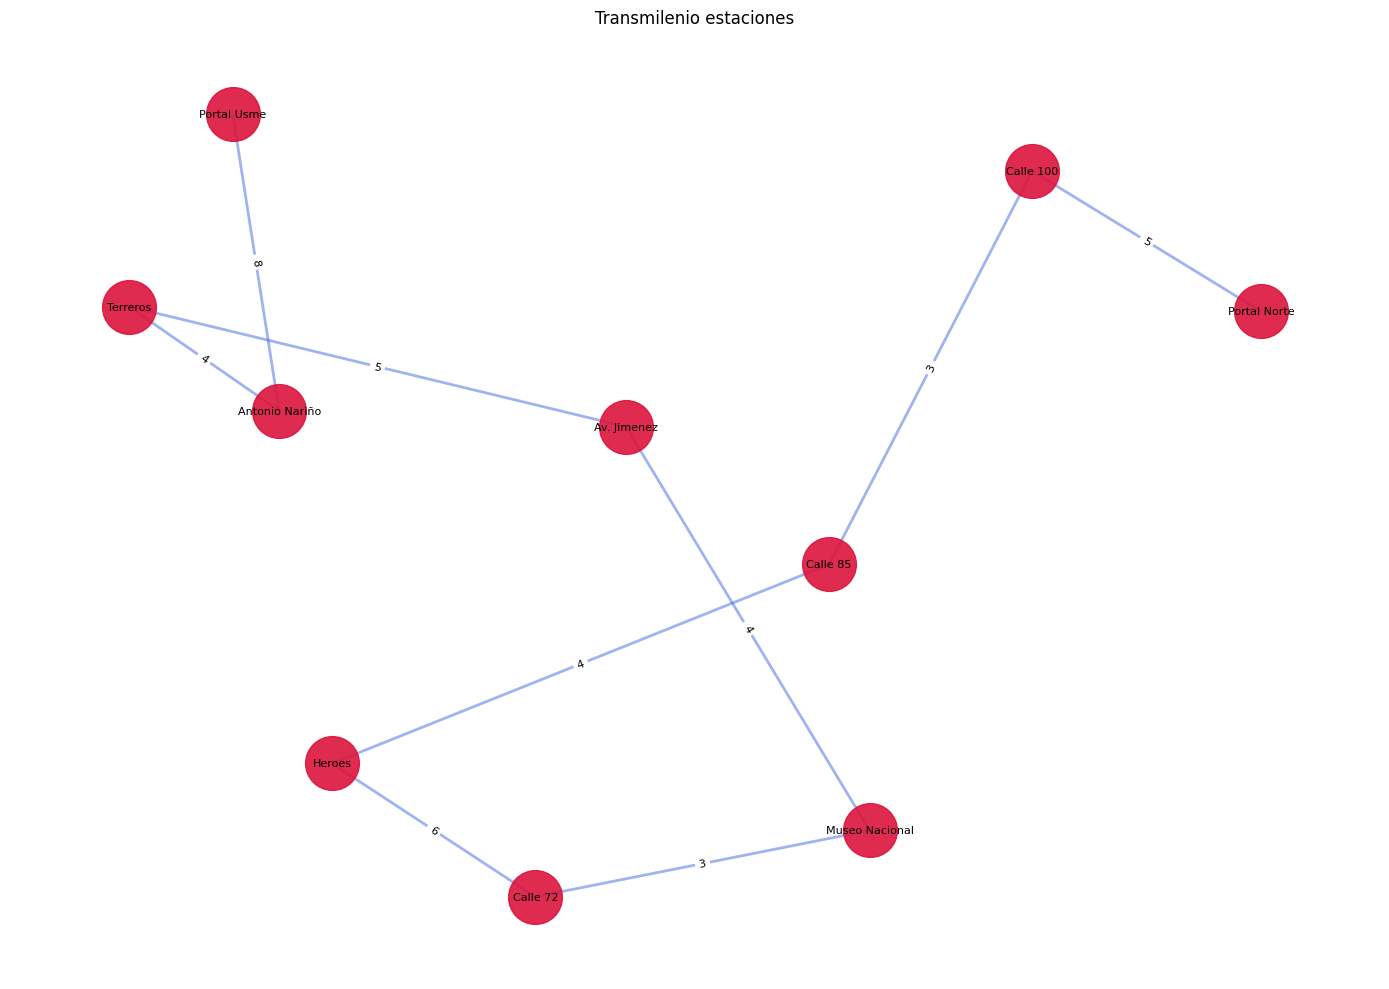

In [69]:
def visualizar_grafo_transmilenio():
  resultado= con.query("""
  MATCH (e1:Estacion)-[r:CONECTA_CON]->(e2:Estacion)
  WHERE id(e1)<id(e2)
  RETURN e1.nombre as Origen, e2.nombre as Destino, r.tiempo_minutos as Tiempo
  """)
  G = nx.Graph()
  for record in resultado:
      G.add_edge(record['Origen'], record['Destino'], weight=record['Tiempo'])

  #-----pinto el grafo----
  plt.figure(figsize=(14, 10))
  pos = nx.spring_layout(G, k=2, iterations=50)

  nx.draw_networkx_nodes(G, pos,node_color='#DC143C', node_size=1500,alpha=0.9)
  nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
  nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='#4169E1')
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
  plt.title ("Transmilenio estaciones")
  plt.axis('off')
  plt.tight_layout()
  plt.show()

visualizar_grafo_transmilenio()

#3.2. Red doméstica de vuelos (en Colombia)

In [11]:
#Limpiar la base de datos en NEO4J
con.execute("""
MATCH (n)
WHERE n:Aeropuerto OR n:Aerolinea
DETACH DELETE n
""")

In [13]:
aeropuertos = [
    {"codigo": "BOG", "ciudad": "Bogotá", "nombre": "El Dorado", "region": "Andina"},
    {"codigo": "MDE", "ciudad": "Medellín", "nombre": "José María Córdova", "region": "Andina"},
    {"codigo": "CLO", "ciudad": "Cali", "nombre": "Alfonso Bonilla Aragón", "region": "Pacífica"},
    {"codigo": "BAQ", "ciudad": "Barranquilla", "nombre": "Ernesto Cortissoz", "region": "Caribe"},
    {"codigo": "CTG", "ciudad": "Cartagena", "nombre": "Rafael Núñez", "region": "Caribe"},
    {"codigo": "SMR", "ciudad": "Santa Marta", "nombre": "Simón Bolívar", "region": "Caribe"},
    {"codigo": "PEI", "ciudad": "Pereira", "nombre": "Matecaña", "region": "Andina"},
    {"codigo": "BGA", "ciudad": "Bucaramanga", "nombre": "Palonegro", "region": "Andina"},
    {"codigo": "CUC", "ciudad": "Cúcuta", "nombre": "Camilo Daza", "region": "Andina"}
]

for aeropuerto in aeropuertos:
    query = f"CREATE (n:Aeropuerto {{nombre:'{aeropuerto['nombre']}', codigo:'{aeropuerto['codigo']}', ciudad:'{aeropuerto['ciudad']}', region:'{aeropuerto['region']}' }})"
    con.execute(query)
    print(f"Aeropuerto creado: '{aeropuerto['nombre']}'")

# for aero in aeropuertos:
#     con.execute("""
#     CREATE (a:Aeropuerto {codigo: $codigo, ciudad: $ciudad,
#                           nombre: $nombre, region: $region})
#     """, aero)
print(f" se crearon {len(aeropuertos)} aeropuertos")

Aeropuertos creados: 'El Dorado'
Aeropuertos creados: 'José María Córdova'
Aeropuertos creados: 'Alfonso Bonilla Aragón'
Aeropuertos creados: 'Ernesto Cortissoz'
Aeropuertos creados: 'Rafael Núñez'
Aeropuertos creados: 'Simón Bolívar'
Aeropuertos creados: 'Matecaña'
Aeropuertos creados: 'Palonegro'
Aeropuertos creados: 'Camilo Daza'
 se crearon 9 aeropuertos


In [14]:
# Crear vuelos directos con duración y frecuencia semanal
vuelos = [
    ("BOG", "MDE", 55, 45),  # duración en minutos, frecuencia semanal
    ("BOG", "CLO", 60, 35),
    ("BOG", "BAQ", 90, 30),
    ("BOG", "CTG", 85, 28),
    ("BOG", "PEI", 50, 25),
    ("BOG", "BGA", 45, 20),
    ("BOG", "CUC", 70, 18),
    ("MDE", "CLO", 55, 20),
    ("MDE", "CTG", 75, 15),
    ("MDE", "PEI", 40, 12),
    ("CLO", "CTG", 80, 10),
    ("BAQ", "CTG", 30, 25),
    ("BAQ", "SMR", 40, 20),
    ("CTG", "SMR", 35, 15),
    ("MDE", "BAQ", 80, 12)
]

for origen, destino, duracion, frecuencia in vuelos:
    con.execute("""
    MATCH (a1:Aeropuerto {codigo: $origen})
    MATCH (a2:Aeropuerto {codigo: $destino})
    CREATE (a1)-[:VUELO_DIRECTO {duracion_min: $duracion, frecuencia_semanal: $frecuencia}]->(a2)
    CREATE (a2)-[:VUELO_DIRECTO {duracion_min: $duracion, frecuencia_semanal: $frecuencia}]->(a1)
    """, {"origen": origen, "destino": destino, "duracion": duracion, "frecuencia": frecuencia})
print(f"Se crearon {len(vuelos)} bidireccionales")

Se crearon 15 bidireccionales


# Consultas

In [15]:
# ruta más rapida entre cucuta (CUC) y cartagena (CTG)
resultado= con.query("""
MATCH path = shortestPath(
    (inicio:Aeropuerto {codigo: 'BGA'})-[:VUELO_DIRECTO*]-(fin:Aeropuerto {codigo: 'SMR'})
)
WITH path,
[r in relationships(path) | r.duracion_min] as duracion_min,
[n in nodes(path) | n.ciudad] as ciudades
RETURN ciudades as Ruta, reduce (total=0, x in duracion_min | total + x) as Duracion_total, length(path) as Escalas
""")
for record in resultado:
    print(f"Ruta: {record['Ruta']}")
    print(f"Duración total: {record['Duracion_total']}")
    print(f"Escalas: {record['Escalas']}")

Ruta: ['Bucaramanga', 'Bogotá', 'Barranquilla', 'Santa Marta']
Duración total: 175
Escalas: 3


#Visualización

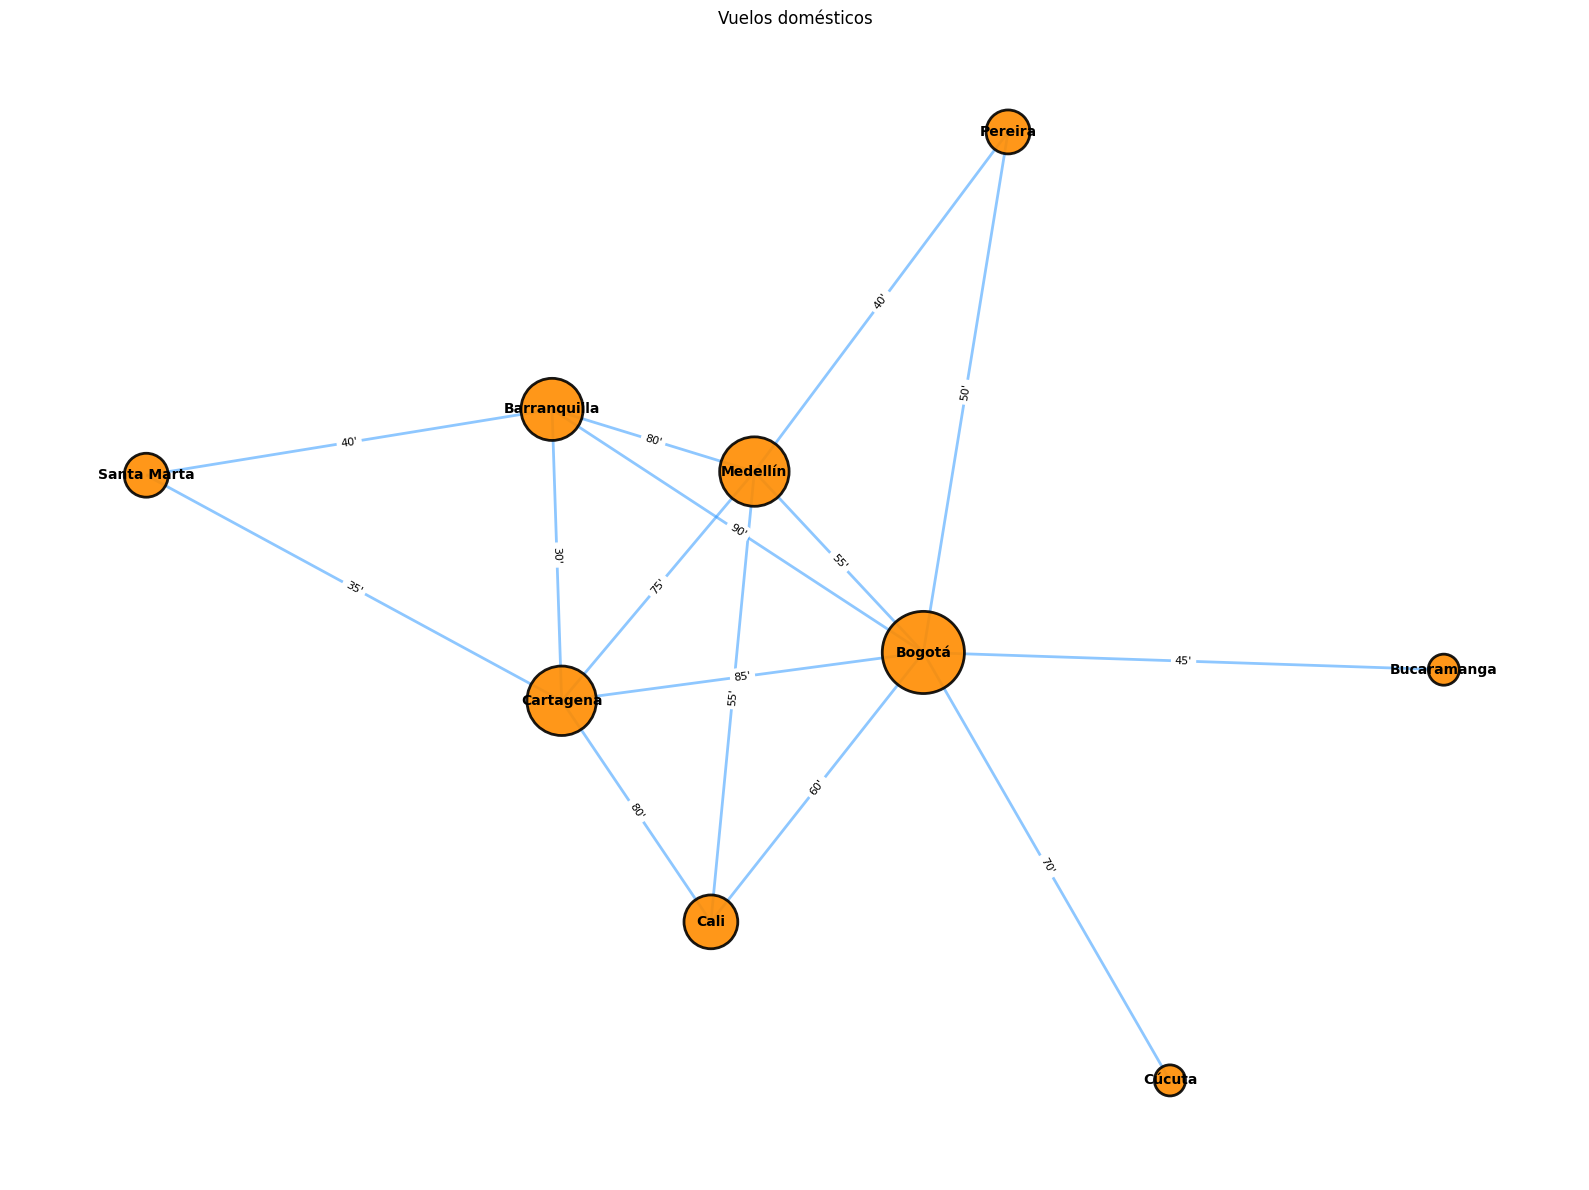

In [16]:
resultado= con.query("""
MATCH (a1:Aeropuerto)-[r:VUELO_DIRECTO]->(a2:Aeropuerto)
WHERE id(a1)<id(a2)
RETURN a1.codigo as origen,a1.ciudad as ciudad_origen,
a2.codigo as destino, a2.ciudad as ciudad_destino,
r.duracion_min as duracion, r.frecuencia_semanal as frecuencia
""")
G = nx.Graph()
for record in resultado:
    G.add_edge(record['ciudad_origen'], record['ciudad_destino'], weight=record['duracion'],frecuencia=record['frecuencia'])
#------codigo para visualizar el grafo
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Tamaño de nodo basado en conectividad
node_sizes = [G.degree(node) * 500 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color='#FF8C00',
                      node_size=node_sizes, alpha=0.9,
                      edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='#1E90FF')

edge_labels = {(u, v): f"{d['weight']}'" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
plt.title("Vuelos domésticos")
plt.axis('off')
plt.tight_layout()
plt.show()


In [17]:
# ruta más rapida entre Pereira (PEI) y Santa Marta (SMR)
resultado= con.query("""
MATCH path = shortestPath(
    (inicio:Aeropuerto {codigo: 'PEI'})-[:VUELO_DIRECTO*]-(fin:Aeropuerto {codigo: 'SMR'})
)
WITH path,
[r in relationships(path) | r.duracion_min] as duracion_min,
[n in nodes(path) | n.ciudad] as ciudades
RETURN ciudades as Ruta, reduce (total=0, x in duracion_min | total + x) as Duracion_total, length(path) as Escalas
""")
for record in resultado:
    print(f"Ruta: {record['Ruta']}")
    print(f"Duración total: {record['Duracion_total']}")
    print(f"Escalas: {record['Escalas']}")

Ruta: ['Pereira', 'Bogotá', 'Barranquilla', 'Santa Marta']
Duración total: 180
Escalas: 3


In [25]:
# Consulta para encontrar todos los vuelos directos desde
airport_code = "BOG"

print(f"Vuelos directos desde {airport_code}:")
resultado_vuelos_directos = con.query("""
MATCH (a1:Aeropuerto {codigo: $code})-[r:VUELO_DIRECTO]->(a2:Aeropuerto)
RETURN a2.ciudad AS Destino, r.duracion_min AS Duracion, r.frecuencia_semanal AS Frecuencia
""", {"code": airport_code})

if resultado_vuelos_directos:
    for record in resultado_vuelos_directos:
        print(f"  Hacia {record['Destino']}: Duración - {record['Duracion']} min, Frecuencia - {record['Frecuencia']} vuelos/semana")
else:
    print(f" Nose tienen vuelos directos desde {airport_code}.")

Vuelos directos desde BOG:
  Hacia Medellín: Duración - 55 min, Frecuencia - 45 vuelos/semana
  Hacia Cali: Duración - 60 min, Frecuencia - 35 vuelos/semana
  Hacia Barranquilla: Duración - 90 min, Frecuencia - 30 vuelos/semana
  Hacia Cartagena: Duración - 85 min, Frecuencia - 28 vuelos/semana
  Hacia Pereira: Duración - 50 min, Frecuencia - 25 vuelos/semana
  Hacia Bucaramanga: Duración - 45 min, Frecuencia - 20 vuelos/semana
  Hacia Cúcuta: Duración - 70 min, Frecuencia - 18 vuelos/semana


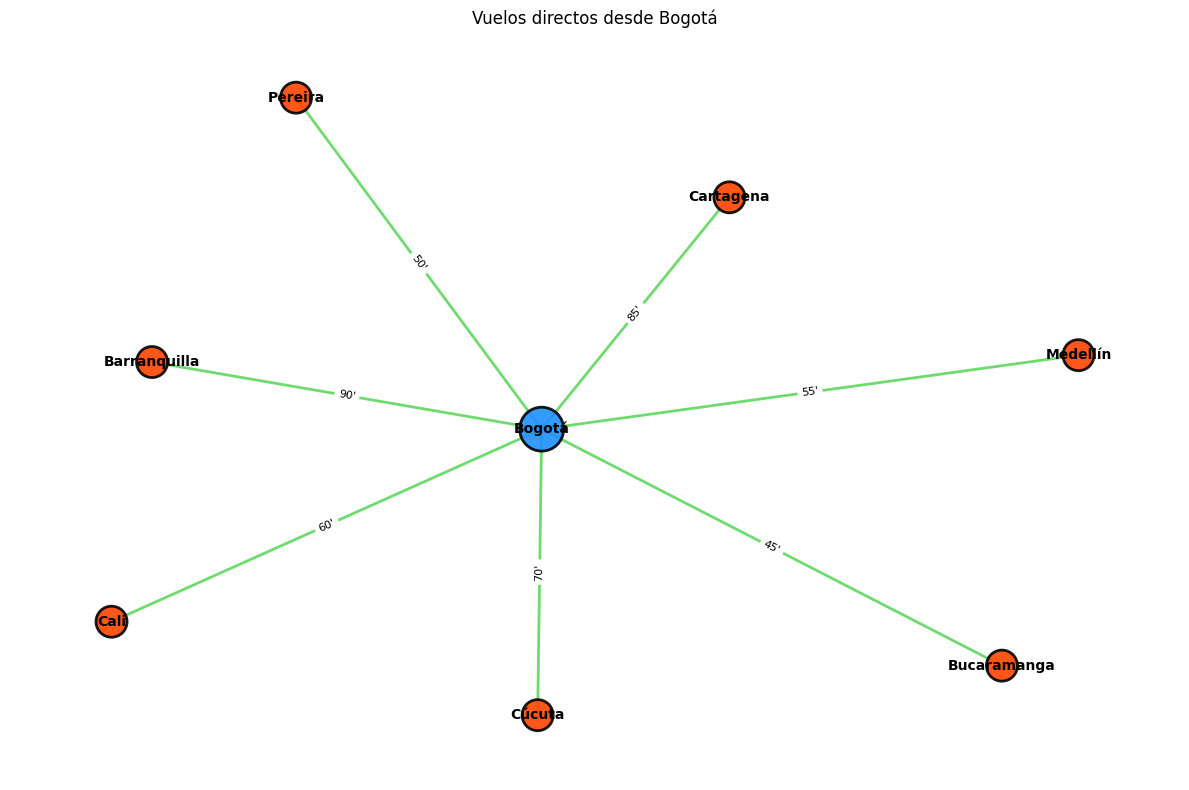

In [28]:
resultado= con.query("""
MATCH (a1:Aeropuerto {codigo: 'BOG'})-[r:VUELO_DIRECTO]->(a2:Aeropuerto)
RETURN a1.codigo as origen,a1.ciudad as ciudad_origen,
a2.codigo as destino, a2.ciudad as ciudad_destino,
r.duracion_min as duracion, r.frecuencia_semanal as frecuencia
""")
G = nx.Graph()
for record in resultado:
    G.add_edge(record['ciudad_origen'], record['ciudad_destino'], weight=record['duracion'],frecuencia=record['frecuencia'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Separar el nodo Bogotá de los otros mediante un estilo diferente
bogota_node = 'Bogotá'
other_nodes = [node for node in G.nodes() if node != bogota_node]

node_sizes = [G.degree(node) * 500 if node != bogota_node else 1000 for node in G.nodes()]
node_colors = ['#FF4500' if node != bogota_node else '#1E90FF' for node in G.nodes()]


nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                      node_size=node_sizes, alpha=0.9,
                      edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='#32CD32')

edge_labels = {(u, v): f"{d['weight']}'" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
plt.title(f"Vuelos directos desde {bogota_node}")
plt.axis('off')
plt.tight_layout()
plt.show()